In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances

In [3]:
# Load dataset
df = pd.read_csv("output_with_anomalies.csv")

# Select required columns
columns_of_interest = ["fldInvoiceAmount", "fldVendorName", "fldTransactions", "fldVendorNo"]
data = df[columns_of_interest]

# Handle missing values
data = data.dropna()

# Scale numerical fields
scaler = StandardScaler()
data['InvoiceAmountScaled'] = scaler.fit_transform(data[['fldInvoiceAmount']])

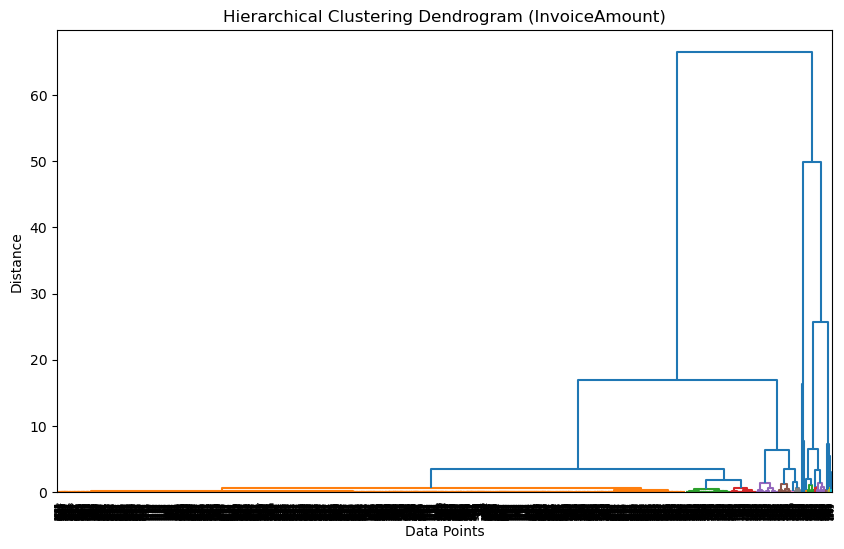

In [4]:
# Hierarchical clustering on scaled invoice amounts
Z_invoice = linkage(data[['InvoiceAmountScaled']], method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z_invoice, labels=data.index, color_threshold=1.5)
plt.title('Hierarchical Clustering Dendrogram (InvoiceAmount)')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

# Assign clusters and detect anomalies
threshold = 1.5  # Adjust threshold based on the dendrogram
data['Cluster_Invoice'] = fcluster(Z_invoice, t=threshold, criterion='distance')

# Detect outliers: Identify clusters with few members
cluster_sizes = data['Cluster_Invoice'].value_counts()
anomaly_clusters = cluster_sizes[cluster_sizes < 5].index  # Clusters with fewer data points
data['Anomaly_InvoiceAmount'] = data['Cluster_Invoice'].apply(lambda x: 'Yes' if x in anomaly_clusters else 'No')


### VendorName Anomalies with TF-IDF and Hierarchical Clustering

C:\Users\Dhireen Kumar Rajak\AppData\Local\Temp\ipykernel_11100\2344182557.py:9: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_vendor = linkage(cosine_dist, method='ward')


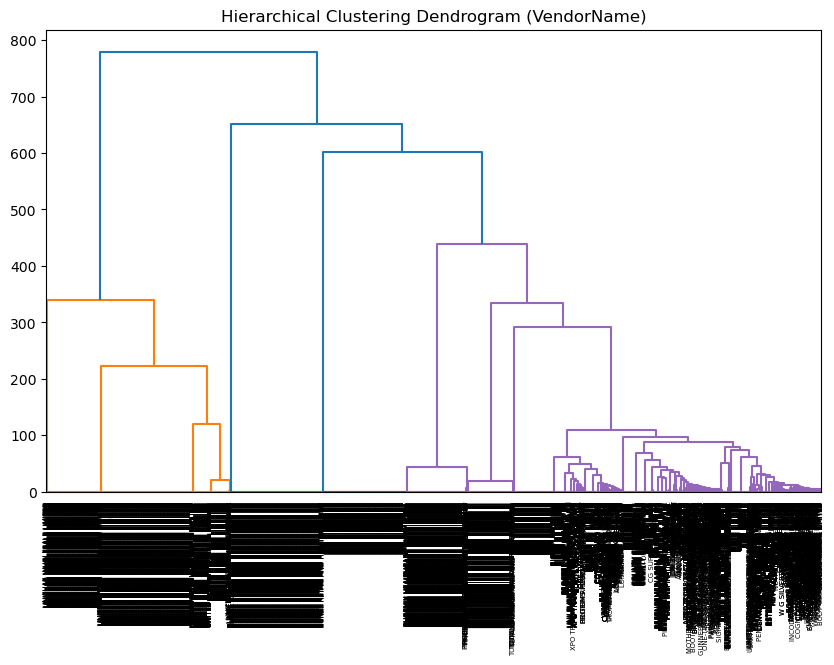

In [5]:
# Convert VendorName to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['fldVendorName'])

# Compute cosine distances
cosine_dist = cosine_distances(tfidf_matrix)

# Perform hierarchical clustering on cosine distances
Z_vendor = linkage(cosine_dist, method='ward')

# Plot dendrogram for VendorName
plt.figure(figsize=(10, 6))
dendrogram(Z_vendor, labels=data['fldVendorName'].values, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (VendorName)")
plt.show()

# Identify clusters and anomalies
threshold_vendor = 1.0  # Adjust based on dendrogram
data['VendorNameCluster'] = fcluster(Z_vendor, t=threshold_vendor, criterion='distance')

# Detect outliers: Small clusters indicate anomalies
cluster_sizes = data['VendorNameCluster'].value_counts()
small_clusters = cluster_sizes[cluster_sizes == 1].index  # Clusters with single elements
data['Anomaly_VendorName'] = data['VendorNameCluster'].apply(lambda x: 'Yes' if x in small_clusters else 'No')

### CurrencyType Anomalies with Hierarchical Clustering

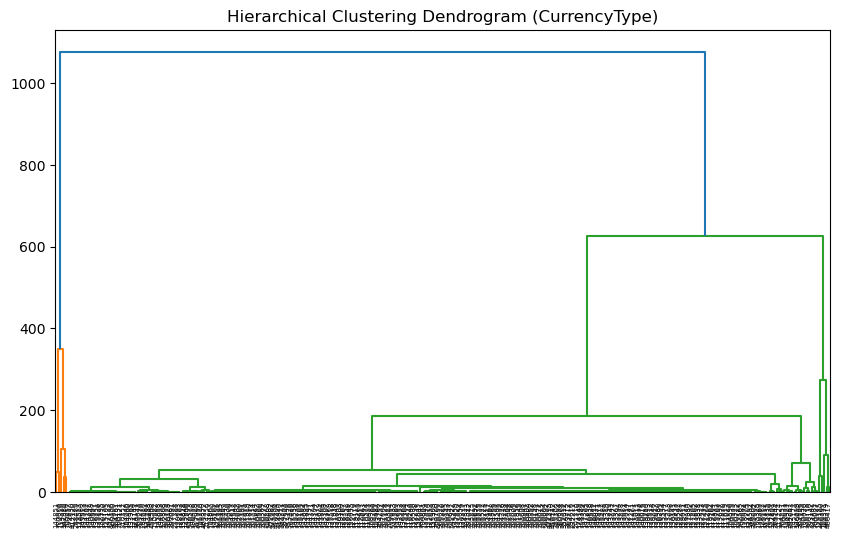

In [6]:
# One-Hot Encode CurrencyType
ohe = OneHotEncoder()
currency_encoded = ohe.fit_transform(data[['fldTransactions']])

# Aggregate CurrencyType by VendorIdNumber
currency_df = pd.DataFrame(currency_encoded.toarray(), columns=ohe.get_feature_names_out())
currency_df['fldVendorNo'] = data['fldVendorNo']
currency_agg = currency_df.groupby('fldVendorNo').sum()

# Perform hierarchical clustering on aggregated currency patterns
Z_currency = linkage(currency_agg, method='ward')

# Plot dendrogram for CurrencyType
plt.figure(figsize=(10, 6))
dendrogram(Z_currency, labels=currency_agg.index, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (CurrencyType)")
plt.show()

# Identify clusters and anomalies
threshold_currency = 2.0  # Adjust based on dendrogram
currency_agg['Cluster'] = fcluster(Z_currency, t=threshold_currency, criterion='distance')

# Find vendors with unusual CurrencyType
def detect_currency_anomalies(vendor_id):
    vendor_data = currency_df[currency_df['fldVendorNo'] == vendor_id]
    return 'Yes' if (vendor_data.iloc[:, :-1] > 0).sum().sum() > 1 else 'No'

data['Anomaly_CurrencyType'] = data['fldVendorNo'].apply(detect_currency_anomalies)

In [7]:
# Final anomaly column
data['Anomalies'] = data.apply(
    lambda row: 'Yes' if row['Anomaly_InvoiceAmount'] == 'Yes' or 
                            row['Anomaly_VendorName'] == 'Yes' or 
                            row['Anomaly_CurrencyType'] == 'Yes' 
                else 'No', axis=1)

# Save output
output = pd.concat([df, data[['Anomalies', 'Anomaly_InvoiceAmount', 'Anomaly_VendorName', 'Anomaly_CurrencyType']]], axis=1)
output.to_csv("output.csv", index=False)
print("Output CSV with anomalies saved!")

Output CSV with anomalies saved!


In [ ]:
# Example scatter plot for InvoiceAmount anomalies
# plt.figure(figsize=(8, 5))
# sns.scatterplot(data=data, x='InvoiceAmount', y='Cluster', hue='Anomaly_InvoiceAmount', palette='deep')
# plt.title('InvoiceAmount Anomalies')
# plt.show()

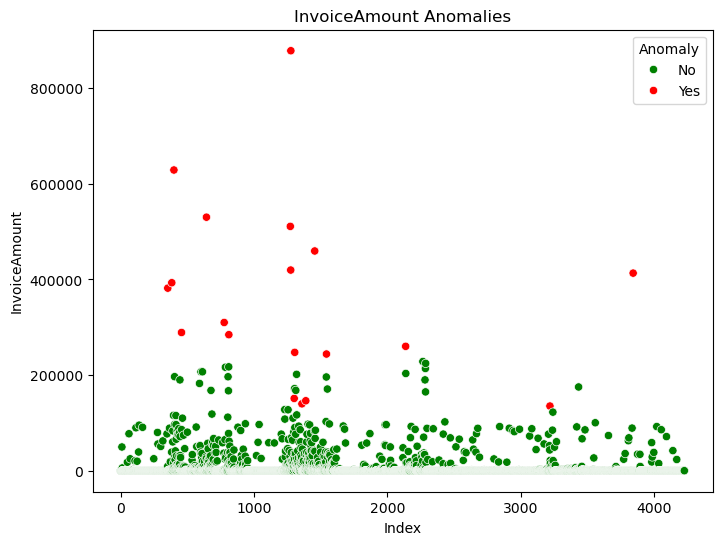

In [8]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data.index, y=data['fldInvoiceAmount'], hue=data['Anomaly_InvoiceAmount'],
                palette={'Yes': 'red', 'No': 'green'})
plt.title("InvoiceAmount Anomalies")
plt.xlabel("Index")
plt.ylabel("InvoiceAmount")
plt.legend(title="Anomaly")
plt.show()

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA on TF-IDF matrix to reduce to 2D
pca = PCA(n_components=2)
tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())

# Scatter plot of VendorName clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tfidf_pca[:, 0], y=tfidf_pca[:, 1], hue=data['Anomaly_VendorName'],
                palette={'Yes': 'red', 'No': 'green'})
plt.title("VendorName Anomalies (TF-IDF + PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Anomaly")
plt.show()

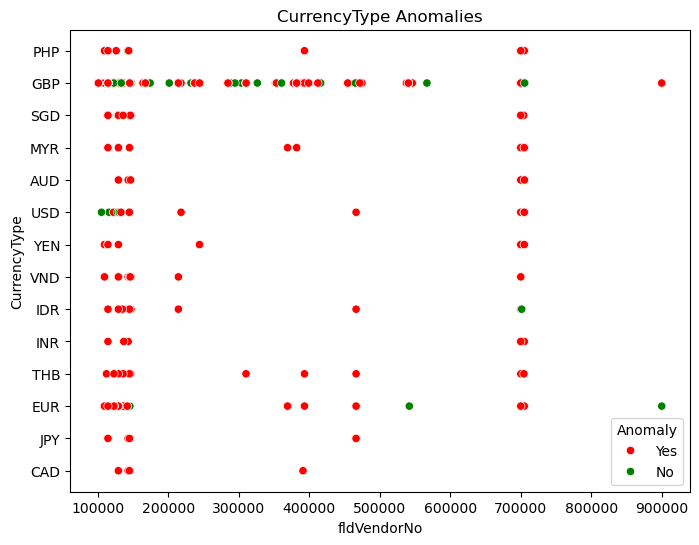

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['fldVendorNo'], y=data['fldTransactions'], hue=data['Anomaly_CurrencyType'],
                palette={'Yes': 'red', 'No': 'green'})
plt.title("CurrencyType Anomalies")
plt.xlabel("fldVendorNo")
plt.ylabel("CurrencyType")
plt.legend(title="Anomaly")
plt.show()